In [1]:
import numpy as np
from scipy import stats
import math as m
import time
%matplotlib inline
from matplotlib import pyplot as plt
from Duguid_1946 import total_talk_small, total_talk_large, volume_small, volume_large, \
diameter_small, diameter_large, talk_small, talk_large
from Chen_2020 import distance, eSR, eLD
from van_Doremalen_2020 import viral_half_lives
from Chen_Bobrovitz_2020 import viral_load
from pulmonary_rate import pulmonary_rate

seed = int(time.time())
print('seed:', seed)

ranD = np.random.default_rng(seed)

''' iterations '''
N = 200000 


seed: 1627547638


Exposure via (I) short range aerosols and large droplet deposition and (II) long range aerosols for person A, standing 1.5m and person B standing more than 2m away from infector in a room for 30 minutes, all having entered at the same time.  Relative reductions in exposure calculated for the following interventions

1. Increasing the ventilation rate fourfold
2. Infector wears a mask, with baseline ventilation rate
3. Infector and persons A & B wear a mask, with baseline ventilation rate
4. Infector and persons A & B wear a mask and fourfold increase in ventilation rate

In [2]:
'''
solution to dx/dt = a - b*x(t), x(0) = x0
assume all inputs are numpy ndarrays

t.shape = (m,1) OR (1,)
a.shape = b.shape = x0.shape = (1,n) OR (1,)
'''
def xs(t, a, b, x0):
    
    factor1 = np.exp( np.multiply(-b, t) )
    factor2 = np.subtract(  x0, np.divide(a, b) )
    ret = np.multiply( factor1, factor2 )
    np.add( ret, np.divide(a,b), out=ret )
    return ret

'''
definite integral of solution to dx/dt = a - b*x(t), x(0) = x0
from t = t0 to t1
assume all inputs are numpy ndarrays
'''
def xs_int(a, b, x0, t0, t1):

    ret = np.multiply( a, np.subtract(t1, t0) ) - xs(np.subtract(t1, t0), a, b, x0) + x0
    return np.divide(ret, b)


# Short range exposure


## Rate of exposure to respiratory fluid (Chen 2020)

Table below shows exposure (ul) to respiratory fluid when standing at a range of distances from someone counting aloud from 1 to 100 via

    (a) close range inhalation of expired aerosols (eSR)
    (b) deposition onto mucous membranes (eLD)
    
    (source: Short-range airborne route dominates exposure of respiratory infection during close contact, Chen et al. 2020, Figure A1b)

In [3]:
print('Dist[m]\teSR (ul)\teLD (ul)')
print('--------------------------------------------------------')
for d,s,l in zip(distance, eSR, eLD):
    print('%s\t%.4e\t%.4e' %(d,s,l))


Dist[m]	eSR (ul)	eLD (ul)
--------------------------------------------------------
0.1	2.3988e-02	2.5119e-01
0.5	1.3804e-04	7.9433e-06
1.0	6.0256e-06	4.6774e-08
1.5	8.9125e-07	3.6308e-09
2.0	2.5119e-07	4.1687e-10


## Model description

$e_{\text{SR}},\,e_{\text{LD}}$ = exposure to short range aerosols / large droplets at distance $d$ - counting 1-100 (microlitres)

$\phi =$ respiratory viral load (RNA per ul) [Chen, Bobrovitz et al. (2021)]

$m_{\text{src, LD}},\, m_{\text{recip, LD}} = $ mask efficacy for source/recipient - "large" droplets (> 20 microns)

$m_{\text{src, SD}},\, m_{\text{recip, SD}} = $ mask efficacy for source/recipient - "small" droplets (<= 20 microns)

$q_{\text{short range}} = \phi \big\{e_{\text{LD}}(1 - m_{\text{src, LD}})(1 - m_{\text{recip, LD}}) + e_{\text{SR}}(1 - m_{\text{src, SD}})(1 - m_{\text{recip, SD}})\big\}$ - RNA copies per min

# Long range exposure via aerosols

## Respiratory fluid volume (Duguid 1946)


Volume of resp. fluid from counting 1-100 over one minute for small (<= 20 micron) & large (> 20 micron) particles 

In [4]:
print('"small particles" (counting 1-100):')
print('diam [micron]\t\tn\t\tvolume rate [ul per min]')
print('----------------------------------------------------------------')
for d, n, v in zip(diameter_small, talk_small, volume_small):
    print('%s\t\t\t%d\t\t%.4e' %(d,n,v*1e9))
print('----------------------------------------------------------------')    
print('total\t\t\t-\t\t%.4e' %np.sum(total_talk_small))
print('\n"large particles" (counting 1-100):')
print('diam [micron]\t\tn\t\tvolume rate [ul per min]')
print('----------------------------------------------------------------')
for d, n, v in zip(diameter_large, talk_large, volume_large):
    print('%s\t\t\t%d\t\t%.4e' %(d,n,v*1e9))
print('----------------------------------------------------------------')    
print('total\t\t\t-\t\t%.4e' %np.sum(total_talk_large))
    

"small particles" (counting 1-100):
diam [micron]		n		volume rate [ul per min]
----------------------------------------------------------------
1.5			1		1.7671e-09
3			13		1.4137e-08
6			52		1.1310e-07
12			78		9.0478e-07
20			40		4.1888e-06
----------------------------------------------------------------
total			-		2.4419e-04

"large particles" (counting 1-100):
diam [micron]		n		volume rate [ul per min]
----------------------------------------------------------------
28			24		1.1494e-05
36			12		2.4429e-05
45			6		4.7713e-05
62.5			7		1.2783e-04
87.5			5		3.5077e-04
112.5			4		7.4551e-04
137.5			3		1.3612e-03
175			2		2.8062e-03
225			1		5.9641e-03
375			3		2.7612e-02
750			1		2.2089e-01
1500			0		1.7671e+00
----------------------------------------------------------------
total			-		3.2587e-01


## Model description

<b>Airborne concentration over time, $C(t)$ [RNA per m$^{-3}$], is the solution to</b>

$\frac{dC}{dt} = -\Big(\frac{Q}{V} + \gamma_{\text{air}} \Big)C + \frac{q_{\text{aer}}}{V}$

with $C(0) = c_0$

where, 

$V,\,Q =$ room volume [$m^3$] and ventilation rate [m$^3$ per min]

$\gamma_{\text{air}} =$ pathogen decay rate (air) [per min] [van Doremalen et al. (2020)]

and $q_{\text{aer}} = \phi \times V_{\text{small}} \times (1 - m_{\text{src, SD}})$

$V_{\text{small}}$ = volume of respiratory droplets with diameter 20 microns or less emitted in one minute due to counting loudly from 1 to 100 (Duguid 1946, see above table, volumes given in ul) [m$^3$ per min]

$\phi =$ respiratory viral load [RNA per m$^{-3}$] [Chen, Bobrovitz et al. (2021) - given there in ml]

$m_{\text{src, SD}} = $ infector mask efficacy for small droplets

<b>Aerosol exposure after time $t$ min is then</b>

$E(t) = (1 - m_{\text{recip, SD}}) \times p \times \int_{t_0}^{t_1} C(u)\,du$

$m_{\text{recip, SD}} = $ mask efficacy (small droplets)

$p =$ pulmonary rate (m$^3$ per min)

In [5]:
def exposure_short_range(duration, #[min]
                         viral_load, #[RNA per ml]
                         eSR, #[ul per min]
                         eLD, #[ul per min]
                         mask_source_SD, #[]               
                         mask_source_LD, #[]
                         mask_recip_SD, #[]
                         mask_recip_LD): #[]

    dose = (1 - mask_source_LD) * eLD * (1 - mask_recip_LD) #[ul per min]
    dose += (1 - mask_source_SD) * eSR * (1 - mask_recip_SD) #[ul per min]

    dose *= viral_load * duration / 1000 #RNA
    
    return dose

def exposure_long_range_aerosol(duration, #[
                                min] 
                     viral_load, #[RMA per ml]
                     vol_resp_fl_small_talking, #[ul per min]           
                     viral_conc_0, #[RNA per ml]
                     pulmonary_rate, #[m^3 per min]
                     gamma_air, #[per min]
                     mask_source_SD, #[]
                     mask_recip_SD, #[]
                     room_volume, #[m^3]
                     ventilation_rate): #[m^3 per min]

    q = (1 - mask_source_SD) * vol_resp_fl_small_talking * viral_load / 1000     #RNA per min

    a = q / room_volume #RNA per min per cubic metre
    b = ventilation_rate / room_volume + gamma_air #per min

    dose = xs_int(a, b, viral_conc_0, 0.0, duration)

    np.multiply(dose, pulmonary_rate, out=dose)
    np.multiply(dose, (1-mask_recip_SD), out=dose)

    return dose

def make_hist(log_A_e_sr, log_A_e_aer, log_A_e_total, log_B_e_aer, title):

    fig, ax = plt.subplots(2,3)
    fig.set_size_inches(20,12)

    ax[0,0].hist(log_A_e_sr, bins=40, density=True)
    ax[0,1].hist(log_A_e_aer, bins=40, density=True)
    ax[0,2].hist(log_A_e_total, bins=40, density=True)

    ax[1,1].hist(log_B_e_aer, bins=40, density=True)

    fig.suptitle(title)
    ax[0,0].set_title('short range droplets (A)')
    ax[0,0].set_xlabel(r' $\log_{10}$ RNA')
    ax[0,1].set_title('long range aerosols (A)')
    ax[0,2].set_title('total (A)')
    ax[1,1].set_title('long range aerosols (B)')
    plt.show()

## 0. Baseline case

In [6]:
room_area = 5.5*4 #m2
room_height = 2.7 #m
V = room_volume = room_area*room_height

people = 3 #number of people
litrespersecondperperson = 3 #stats.uniform.rvs(1, 5, size=(N,2)) #ventilation in l/s/person

Q_0 = people * litrespersecondperperson * 60 / 1000 #total ventilation rate in m3/min

#convert viral half lives (hr) to decay rate (min^-1)
gamma = {k_:m.log(2)/(v_ * 60) for k_, v_ in zip(viral_half_lives.keys(),
                           viral_half_lives.values())} #per min [van Doremalen (2020)]

src_mask_LD = 0.0 #mask efficacy for large droplets
src_mask_SD = 0.0 #mask efficacy for small droplets

recip_mask_LD = 0.0 #mask efficacy for large droplets
recip_mask_SD = 0.0 #mask efficacy for small droplets

t = 30.0 #min
viral_conc_0 = 0

vl = viral_load( N, ranD )

#pulmonary ventilation rates for A & B
pA = 0.001 * pulmonary_rate(N, ranD) #m^3 per min
pB = 0.001 * pulmonary_rate(N, ranD) #m^3 per min

gamma_air = gamma['aerosol']
vol_resp_fl_small_talking = np.sum(total_talk_small) #Chen2020 + Duguid1946

In [7]:
Q = Q_0
Q_ACH = 60*Q/V

print( 'Room volume: %.2f (m^3)\nVentilation rate: %.2f (m^3 per min), %.2f (ACH)'
    %(V, Q, Q_ACH)
)


A_e_sr = exposure_short_range(t, vl, eSR[3], eLD[3], src_mask_SD, src_mask_LD, recip_mask_SD, recip_mask_LD)
A_e_aer = exposure_long_range_aerosol(t, vl, vol_resp_fl_small_talking, 0.0, pA, gamma_air, src_mask_SD
                                      , recip_mask_SD, V, Q)

B_e_aer = exposure_long_range_aerosol(t, vl, vol_resp_fl_small_talking, 0.0, pB, gamma_air, src_mask_SD
                                      , recip_mask_SD, V, Q)

log_A_e_sr = np.log10(A_e_sr)
log_A_e_aer = np.log10(A_e_aer)
log_A_e_total = np.log10(A_e_sr + A_e_aer)

log_B_e_aer = np.log10(B_e_aer)

mean_exp_A = np.average(A_e_sr + A_e_aer)
mean_exp_B = np.average(B_e_aer)

Room volume: 59.40 (m^3)
Ventilation rate: 0.54 (m^3 per min), 0.55 (ACH)


## 1. Fourfold Increase ventilation rate

In [8]:
Q = 4*Q_0
Q_ACH = 60*Q/V

print( 'Room volume: %.2f (m^3)\nVentilation rate: %.2f (m^3 per min), %.2f (ACH)'
    %(V, Q, Q_ACH)
)

#vl = viral_load( N, ranD )

#pulmonary ventilation rates for A & B
#pA = 0.001 * pulmonary_rate(N, ranD) #m^3 per min
#pB = 0.001 * pulmonary_rate(N, ranD) #m^3 per min

Room volume: 59.40 (m^3)
Ventilation rate: 2.16 (m^3 per min), 2.18 (ACH)


In [9]:
A_e_sr_1 = exposure_short_range(t, vl, eSR[3], eLD[3], src_mask_SD, src_mask_LD, recip_mask_SD, recip_mask_LD)
A_e_aer_1 = exposure_long_range_aerosol(t, vl, vol_resp_fl_small_talking, 0.0, pA, gamma_air, src_mask_SD
                                      , recip_mask_SD, V, Q)

B_e_aer_1 = exposure_long_range_aerosol(t, vl, vol_resp_fl_small_talking, 0.0, pB, gamma_air, src_mask_SD
                                      , recip_mask_SD, V, Q)

log_A_e_sr_1 = np.log10(A_e_sr_1)
log_A_e_aer_1 = np.log10(A_e_aer_1)
log_A_e_total_1 = np.log10(A_e_sr_1 + A_e_aer_1)

log_B_e_aer_1 = np.log10(B_e_aer_1)

mean_exp_A_1 = np.average(A_e_sr_1 + A_e_aer_1)
mean_exp_B_1 = np.average(B_e_aer_1)

rel_reduct_A_1 = (mean_exp_A - mean_exp_A_1)/mean_exp_A * 100
rel_reduct_B_1 = (mean_exp_B - mean_exp_B_1)/mean_exp_B * 100

## 2. Infector wears face covering

In [10]:
Q = Q_0
Q_ACH = 60*Q/V

print( 'Room volume: %.2f (m^3)\nVentilation rate: %.2f (m^3 per min), %.2f (ACH)'
    %(V, Q, Q_ACH)
)

#vl = viral_load( N, ranD )

#pulmonary ventilation rates for A & B
#pA = 0.001 * pulmonary_rate(N, ranD) #m^3 per min
#pB = 0.001 * pulmonary_rate(N, ranD) #m^3 per min

src_mask_LD = 0.99 #mask efficacy for large droplets
src_mask_SD = 0.5 #mask efficacy for small droplets

recip_mask_LD = 0.0 #mask efficacy for large droplets
recip_mask_SD = 0.0 #mask efficacy for small droplets

Room volume: 59.40 (m^3)
Ventilation rate: 0.54 (m^3 per min), 0.55 (ACH)


In [11]:
A_e_sr_2 = exposure_short_range(t, vl, eSR[3], eLD[3], src_mask_SD, src_mask_LD, recip_mask_SD, recip_mask_LD)
A_e_aer_2 = exposure_long_range_aerosol(t, vl, vol_resp_fl_small_talking, 0.0, pA, gamma_air, src_mask_SD
                                      , recip_mask_SD, V, Q)

B_e_aer_2 = exposure_long_range_aerosol(t, vl, vol_resp_fl_small_talking, 0.0, pB, gamma_air, src_mask_SD
                                      , recip_mask_SD, V, Q)

log_A_e_sr_2 = np.log10(A_e_sr_2)
log_A_e_aer_2 = np.log10(A_e_aer_2)
log_A_e_total_2 = np.log10(A_e_sr_2 + A_e_aer_2)

log_B_e_aer_2 = np.log10(B_e_aer_2)

mean_exp_A_2 = np.average(A_e_sr_2 + A_e_aer_2)
mean_exp_B_2 = np.average(B_e_aer_2)

rel_reduct_A_2 = (mean_exp_A - mean_exp_A_2)/mean_exp_A * 100
rel_reduct_B_2 = (mean_exp_B - mean_exp_B_2)/mean_exp_B * 100

## 3. Susceptibles A and B wear face coverings

In [12]:
Q = Q_0
Q_ACH = 60*Q/V

print( 'Room volume: %.2f (m^3)\nVentilation rate: %.2f (m^3 per min), %.2f (ACH)'
    %(V, Q, Q_ACH)
)

#vl = viral_load( N, ranD )

#pulmonary ventilation rates for A & B
#pA = 0.001 * pulmonary_rate(N, ranD) #m^3 per min
#pB = 0.001 * pulmonary_rate(N, ranD) #m^3 per min

src_mask_LD = 0.0 #mask efficacy for large droplets
src_mask_SD = 0.0 #mask efficacy for small droplets

recip_mask_LD = 0.99 #mask efficacy for large droplets
recip_mask_SD = 0.5 #mask efficacy for small droplets

Room volume: 59.40 (m^3)
Ventilation rate: 0.54 (m^3 per min), 0.55 (ACH)


In [13]:
A_e_sr_3 = exposure_short_range(t, vl, eSR[3], eLD[3], src_mask_SD, src_mask_LD, recip_mask_SD, recip_mask_LD)
A_e_aer_3 = exposure_long_range_aerosol(t, vl, vol_resp_fl_small_talking, 0.0, pA, gamma_air, src_mask_SD
                                      , recip_mask_SD, V, Q)

B_e_aer_3 = exposure_long_range_aerosol(t, vl, vol_resp_fl_small_talking, 0.0, pB, gamma_air, src_mask_SD
                                      , recip_mask_SD, V, Q)

log_A_e_sr_3 = np.log10(A_e_sr_3)
log_A_e_aer_3 = np.log10(A_e_aer_3)
log_A_e_total_3 = np.log10(A_e_sr_3 + A_e_aer_3)

log_B_e_aer_3 = np.log10(B_e_aer_3)

mean_exp_A_3 = np.average(A_e_sr_3 + A_e_aer_3)
mean_exp_B_3 = np.average(B_e_aer_3)

rel_reduct_A_3 = (mean_exp_A - mean_exp_A_3)/mean_exp_A * 100
rel_reduct_B_3 = (mean_exp_B - mean_exp_B_3)/mean_exp_B * 100

## 4. Increased ventilation + infector wears face covering

In [14]:
Q = 4*Q_0
Q_ACH = 60*Q/V

print( 'Room volume: %.2f (m^3)\nVentilation rate: %.2f (m^3 per min), %.2f (ACH)'
    %(V, Q, Q_ACH)
)
#vl = viral_load( N, ranD )

#pulmonary ventilation rates for A & B
#pA = 0.001 * pulmonary_rate(N, ranD) #m^3 per min
#pB = 0.001 * pulmonary_rate(N, ranD) #m^3 per min

src_mask_LD = 0.99 #mask efficacy for large droplets
src_mask_SD = 0.5 #mask efficacy for small droplets

recip_mask_LD = 0.0 #mask efficacy for large droplets
recip_mask_SD = 0.0 #mask efficacy for small droplets

Room volume: 59.40 (m^3)
Ventilation rate: 2.16 (m^3 per min), 2.18 (ACH)


In [15]:
A_e_sr_4 = exposure_short_range(t, vl, eSR[3], eLD[3], src_mask_SD, src_mask_LD, recip_mask_SD, recip_mask_LD)
A_e_aer_4 = exposure_long_range_aerosol(t, vl, vol_resp_fl_small_talking, 0.0, pA, gamma_air, src_mask_SD
                                      , recip_mask_SD, V, Q)

B_e_aer_4 = exposure_long_range_aerosol(t, vl, vol_resp_fl_small_talking, 0.0, pB, gamma_air, src_mask_SD
                                      , recip_mask_SD, V, Q)

log_A_e_sr_4 = np.log10(A_e_sr_4)
log_A_e_aer_4 = np.log10(A_e_aer_4)
log_A_e_total_4 = np.log10(A_e_sr_4 + A_e_aer_4)

log_B_e_aer_4 = np.log10(B_e_aer_4)

mean_exp_A_4 = np.average(A_e_sr_4 + A_e_aer_4)
mean_exp_B_4 = np.average(B_e_aer_4)

rel_reduct_A_4 = (mean_exp_A - mean_exp_A_4)/mean_exp_A * 100
rel_reduct_B_4 = (mean_exp_B - mean_exp_B_4)/mean_exp_B * 100

## 5. Increased ventilation + susceptibles A&B wear face coverings

In [16]:
Q = 4*Q_0
Q_ACH = 60*Q/V

print( 'Room volume: %.2f (m^3)\nVentilation rate: %.2f (m^3 per min), %.2f (ACH)'
    %(V, Q, Q_ACH)
)
#vl = viral_load( N, ranD )

#pulmonary ventilation rates for A & B
#pA = 0.001 * pulmonary_rate(N, ranD) #m^3 per min
#pB = 0.001 * pulmonary_rate(N, ranD) #m^3 per min

src_mask_LD = 0.0 #mask efficacy for large droplets
src_mask_SD = 0.0 #mask efficacy for small droplets

recip_mask_LD = 0.99 #mask efficacy for large droplets
recip_mask_SD = 0.5 #mask efficacy for small droplets

Room volume: 59.40 (m^3)
Ventilation rate: 2.16 (m^3 per min), 2.18 (ACH)


In [17]:
A_e_sr_5 = exposure_short_range(t, vl, eSR[3], eLD[3], src_mask_SD, src_mask_LD, recip_mask_SD, recip_mask_LD)
A_e_aer_5 = exposure_long_range_aerosol(t, vl, vol_resp_fl_small_talking, 0.0, pA, gamma_air, src_mask_SD
                                      , recip_mask_SD, V, Q)

B_e_aer_5 = exposure_long_range_aerosol(t, vl, vol_resp_fl_small_talking, 0.0, pB, gamma_air, src_mask_SD
                                      , recip_mask_SD, V, Q)

log_A_e_sr_5 = np.log10(A_e_sr_5)
log_A_e_aer_5 = np.log10(A_e_aer_5)
log_A_e_total_5 = np.log10(A_e_sr_5 + A_e_aer_5)

log_B_e_aer_5 = np.log10(B_e_aer_5)

mean_exp_A_5 = np.average(A_e_sr_5 + A_e_aer_5)
mean_exp_B_5 = np.average(B_e_aer_5)

rel_reduct_A_5 = (mean_exp_A - mean_exp_A_5)/mean_exp_A * 100
rel_reduct_B_5 = (mean_exp_B - mean_exp_B_5)/mean_exp_B * 100

## 6. Infector + susceptibles A&B wear face coverings

In [18]:
Q = Q_0
Q_ACH = 60*Q/V

print( 'Room volume: %.2f (m^3)\nVentilation rate: %.2f (m^3 per min), %.2f (ACH)'
    %(V, Q, Q_ACH)
)
#vl = viral_load( N, ranD )

#pulmonary ventilation rates for A & B
#pA = 0.001 * pulmonary_rate(N, ranD) #m^3 per min
#pB = 0.001 * pulmonary_rate(N, ranD) #m^3 per min

src_mask_LD = 0.99 #mask efficacy for large droplets
src_mask_SD = 0.5 #mask efficacy for small droplets

recip_mask_LD = 0.99 #mask efficacy for large droplets
recip_mask_SD = 0.5 #mask efficacy for small droplets

Room volume: 59.40 (m^3)
Ventilation rate: 0.54 (m^3 per min), 0.55 (ACH)


In [19]:
A_e_sr_6 = exposure_short_range(t, vl, eSR[3], eLD[3], src_mask_SD, src_mask_LD, recip_mask_SD, recip_mask_LD)
A_e_aer_6 = exposure_long_range_aerosol(t, vl, vol_resp_fl_small_talking, 0.0, pA, gamma_air, src_mask_SD
                                      , recip_mask_SD, V, Q)

B_e_aer_6 = exposure_long_range_aerosol(t, vl, vol_resp_fl_small_talking, 0.0, pB, gamma_air, src_mask_SD
                                      , recip_mask_SD, V, Q)

log_A_e_sr_6 = np.log10(A_e_sr_6)
log_A_e_aer_6 = np.log10(A_e_aer_6)
log_A_e_total_6 = np.log10(A_e_sr_6 + A_e_aer_6)

log_B_e_aer_6 = np.log10(B_e_aer_6)

mean_exp_A_6 = np.average(A_e_sr_6 + A_e_aer_6)
mean_exp_B_6 = np.average(B_e_aer_6)

rel_reduct_A_6 = (mean_exp_A - mean_exp_A_6)/mean_exp_A * 100
rel_reduct_B_6 = (mean_exp_B - mean_exp_B_6)/mean_exp_B * 100

## 7. Increased ventilation + infector + susceptibles A&B wear face coverings

In [20]:
Q = 4*Q_0
Q_ACH = 60*Q/V

print( 'Room volume: %.2f (m^3)\nVentilation rate: %.2f (m^3 per min), %.2f (ACH)'
    %(V, Q, Q_ACH)
)
#vl = viral_load( N, ranD )

#pulmonary ventilation rates for A & B
#pA = 0.001 * pulmonary_rate(N, ranD) #m^3 per min
#pB = 0.001 * pulmonary_rate(N, ranD) #m^3 per min

src_mask_LD = 0.99 #mask efficacy for large droplets
src_mask_SD = 0.5 #mask efficacy for small droplets

recip_mask_LD = 0.99 #mask efficacy for large droplets
recip_mask_SD = 0.5 #mask efficacy for small droplets

Room volume: 59.40 (m^3)
Ventilation rate: 2.16 (m^3 per min), 2.18 (ACH)


In [21]:
A_e_sr_7 = exposure_short_range(t, vl, eSR[3], eLD[3], src_mask_SD, src_mask_LD, recip_mask_SD, recip_mask_LD)
A_e_aer_7 = exposure_long_range_aerosol(t, vl, vol_resp_fl_small_talking, 0.0, pA, gamma_air, src_mask_SD
                                      , recip_mask_SD, V, Q)

B_e_aer_7 = exposure_long_range_aerosol(t, vl, vol_resp_fl_small_talking, 0.0, pB, gamma_air, src_mask_SD
                                      , recip_mask_SD, V, Q)

log_A_e_sr_7 = np.log10(A_e_sr_7)
log_A_e_aer_7 = np.log10(A_e_aer_7)
log_A_e_total_7 = np.log10(A_e_sr_7 + A_e_aer_7)

log_B_e_aer_7 = np.log10(B_e_aer_7)

mean_exp_A_7 = np.average(A_e_sr_7 + A_e_aer_7)
mean_exp_B_7 = np.average(B_e_aer_7)

rel_reduct_A_7 = (mean_exp_A - mean_exp_A_7)/mean_exp_A * 100
rel_reduct_B_7 = (mean_exp_B - mean_exp_B_7)/mean_exp_B * 100

## Probability of exposure to 1,10,100 RNA copies

In [22]:
P_A = np.sum(np.greater_equal(log_A_e_total[::,np.newaxis], [0,1,2]),axis=0) / log_A_e_total.size
P_B = np.sum(np.greater_equal(log_B_e_aer[::,np.newaxis], [0,1,2]),axis=0) / log_B_e_aer.size

P_A_1 = np.sum(np.greater_equal(log_A_e_total_1[::,np.newaxis], [0,1,2]),axis=0) / log_A_e_total_1.size
P_B_1 = np.sum(np.greater_equal(log_B_e_aer_1[::,np.newaxis], [0,1,2]),axis=0) / log_B_e_aer_1.size

P_A_2 = np.sum(np.greater_equal(log_A_e_total_2[::,np.newaxis], [0,1,2]),axis=0) / log_A_e_total_2.size
P_B_2 = np.sum(np.greater_equal(log_B_e_aer_2[::,np.newaxis], [0,1,2]),axis=0) / log_B_e_aer_2.size

P_A_3 = np.sum(np.greater_equal(log_A_e_total_3[::,np.newaxis], [0,1,2]),axis=0) / log_A_e_total_3.size
P_B_3 = np.sum(np.greater_equal(log_B_e_aer_3[::,np.newaxis], [0,1,2]),axis=0) / log_B_e_aer_3.size

P_A_4 = np.sum(np.greater_equal(log_A_e_total_4[::,np.newaxis], [0,1,2]),axis=0) / log_A_e_total_4.size
P_B_4 = np.sum(np.greater_equal(log_B_e_aer_4[::,np.newaxis], [0,1,2]),axis=0) / log_B_e_aer_4.size

P_A_5 = np.sum(np.greater_equal(log_A_e_total_5[::,np.newaxis], [0,1,2]),axis=0) / log_A_e_total_5.size
P_B_5 = np.sum(np.greater_equal(log_B_e_aer_5[::,np.newaxis], [0,1,2]),axis=0) / log_B_e_aer_5.size

P_A_6 = np.sum(np.greater_equal(log_A_e_total_6[::,np.newaxis], [0,1,2]),axis=0) / log_A_e_total_6.size
P_B_6 = np.sum(np.greater_equal(log_B_e_aer_6[::,np.newaxis], [0,1,2]),axis=0) / log_B_e_aer_6.size

P_A_7 = np.sum(np.greater_equal(log_A_e_total_7[::,np.newaxis], [0,1,2]),axis=0) / log_A_e_total_7.size
P_B_7 = np.sum(np.greater_equal(log_B_e_aer_7[::,np.newaxis], [0,1,2]),axis=0) / log_B_e_aer_7.size

In [23]:
import pandas as pd

intervention = np.tile(['baseline'
                ,'+vent'
                ,'mask (inf)'
                ,'mask (susc)'
                ,'+vent & mask (inf)'
                ,'+vent & mask (susc)'
                ,'mask (all)'
                ,'+vent & mask (all)'
               ],2)[::,np.newaxis]

susceptible = np.repeat(['A','B'],8)[::,np.newaxis]

dat_ = np.vstack( (P_A, P_A_1, P_A_2, P_A_3
                    ,P_A_4, P_A_5, P_A_6, P_A_7
                    ,P_B, P_B_1, P_B_2, P_B_3
                   ,P_B_4, P_B_5, P_B_6, P_B_7
                  ))

dat = np.concatenate((intervention, susceptible, dat_), axis=1)
tab = pd.DataFrame(data=dat, columns=['intervention', 'susceptible','P(>=1)','P(>=10)','P(>=100)'])
print(tab[susceptible=='A'])
print('----------------------------------------------------------')
print(tab[susceptible=='B'])


          intervention susceptible    P(>=1)   P(>=10) P(>=100)
0             baseline           A  0.271415   0.13494  0.05221
1                +vent           A    0.2714  0.134935   0.0522
2           mask (inf)           A  0.224655   0.10391  0.03739
3          mask (susc)           A  0.224655   0.10391  0.03739
4   +vent & mask (inf)           A  0.224645  0.103895  0.03739
5  +vent & mask (susc)           A  0.224645  0.103895  0.03739
6           mask (all)           A  0.182945    0.0784  0.02597
7   +vent & mask (all)           A  0.182935    0.0784  0.02596
----------------------------------------------------------
           intervention susceptible    P(>=1)   P(>=10)  P(>=100)
8              baseline           B  0.013755  0.002745  0.000345
9                 +vent           B  0.011905  0.002315    0.0003
10           mask (inf)           B  0.008785   0.00153   0.00018
11          mask (susc)           B  0.008785   0.00153   0.00018
12   +vent & mask (inf)           B

## Relative reduction in exposure due to interventions (%)

In [24]:
intervention = ['+vent\t\t'
                ,'mask (inf)\t'
                ,'mask (susc)\t'
                ,'+vent & mask (inf)'
                ,'+vent & mask (susc)'
                ,'mask (all)\t'
                ,'+vent & mask (all)']

dat_A = [rel_reduct_A_1, rel_reduct_A_2, rel_reduct_A_3, rel_reduct_A_4
        , rel_reduct_A_5, rel_reduct_A_6, rel_reduct_A_7]

dat_B = [rel_reduct_B_1, rel_reduct_B_2, rel_reduct_B_3, rel_reduct_B_4
        , rel_reduct_B_5, rel_reduct_B_6, rel_reduct_B_7]

print('intervention\t\tperson A (@1.5m)\tperson B (> 2m)')
print('---------------------------------------------------------------')
for int_, dA, dB in zip(intervention, dat_A, dat_B):
    print('%s\t%.2f\t\t\t%.2f' %(int_, dA, dB))




intervention		person A (@1.5m)	person B (> 2m)
---------------------------------------------------------------
+vent			0.02			20.61
mask (inf)		50.20			50.00
mask (susc)		50.20			50.00
+vent & mask (inf)	50.21			60.31
+vent & mask (susc)	50.21			60.31
mask (all)		75.10			75.00
+vent & mask (all)	75.11			80.15


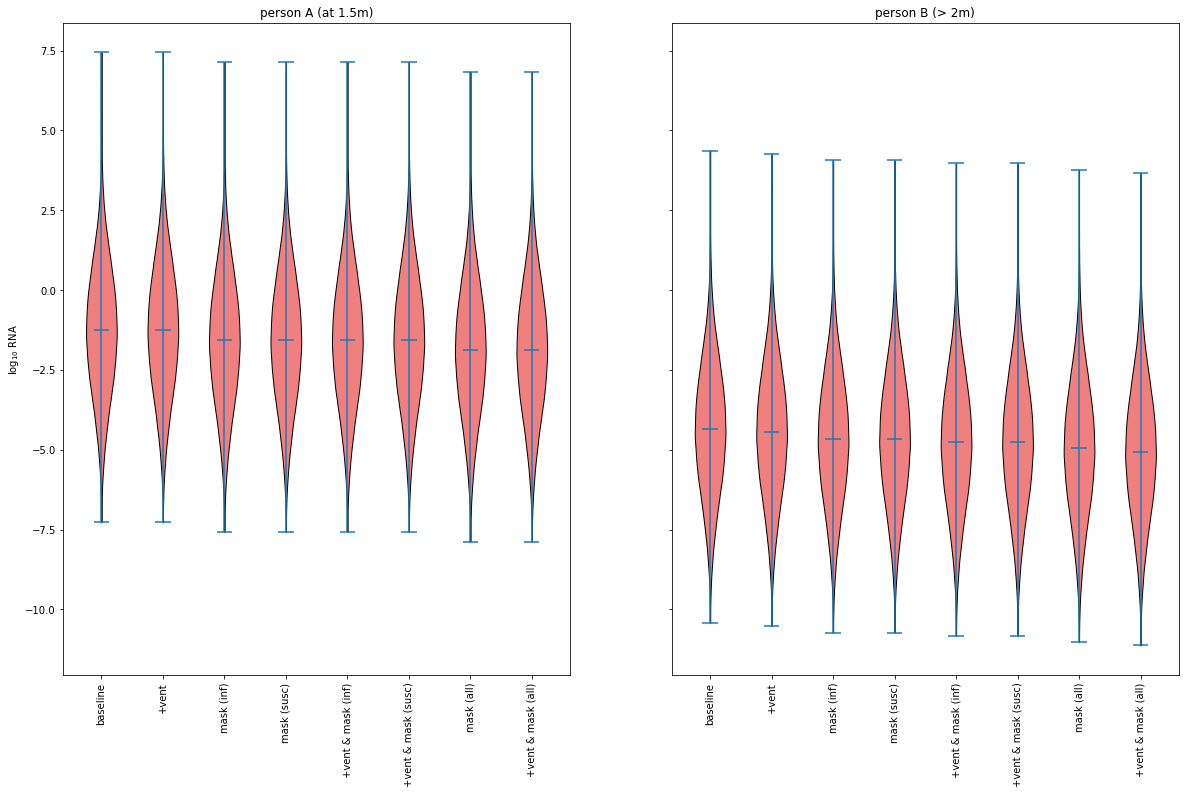

In [25]:
logdoseA = [log_A_e_total, log_A_e_total_1, log_A_e_total_2, log_A_e_total_3, log_A_e_total_4
            , log_A_e_total_5, log_A_e_total_6, log_A_e_total_7]
logdoseB = [log_B_e_aer, log_B_e_aer_1, log_B_e_aer_2, log_B_e_aer_3, log_B_e_aer_4
            , log_B_e_aer_5, log_B_e_aer_6, log_B_e_aer_7]

#for l in logdose:
#    print(np.median(l))

fig, ax = plt.subplots(1,2,sharey=True)
fig.set_size_inches(20,12)

parts = ax[0].violinplot( logdoseA, showmedians=True, showmeans=False, showextrema=True )
for p in parts['bodies']:
    p.set_facecolor('lightcoral')
    p.set_edgecolor('black')
    p.set_alpha(1)

parts = ax[1].violinplot( logdoseB, showmedians=True, showmeans=False, showextrema=True )
for p in parts['bodies']:
    p.set_facecolor('lightcoral')
    p.set_edgecolor('black')
    p.set_alpha(1)

ax[0].set_xticks([1,2,3,4,5,6,7,8])
ax[1].set_xticks([1,2,3,4,5,6,7,8])
ax[0].set_xticklabels(['baseline'
                ,'+vent'
                ,'mask (inf)'
                ,'mask (susc)'
                ,'+vent & mask (inf)'
                ,'+vent & mask (susc)'
                ,'mask (all)'
                ,'+vent & mask (all)'],rotation='vertical')
ax[1].set_xticklabels(['baseline'
                ,'+vent'
                ,'mask (inf)'
                ,'mask (susc)'
                ,'+vent & mask (inf)'
                ,'+vent & mask (susc)'
                ,'mask (all)'
                ,'+vent & mask (all)'],rotation='vertical')

ax[0].set_ylabel(r'$\log_{10}$ RNA')
ax[0].set_title('person A (at 1.5m)')
ax[1].set_title('person B (> 2m)')

    
plt.show()